In [3]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# CSV einlesen (Achtung keine / in den Spaltenüberschriften wegen späterem Namen)
# geht davon aus, dass keine Fehler in der Datei sind und alle Felder richtig gefüllt
df = pd.read_csv('input/20190215LPS_CFD.csv', sep=';', usecols=[9,11,18], parse_dates=[1,2], encoding='iso8859_15')

df.columns = ['art', 'input', 'out']

feiertage = ['2018-10-03', # Tag der Einheit
             '2018-11-01', # Allerheiligen
             '2018-12-24', # Heiligabend
             '2018-12-25', # Weihnachten
             '2018-12-26', # Weihnachten
             '2018-12-31', # Silvester
             '2019-01-01'  # Neujahr
            ]

# astype('datetime64[D]') notwendig
dauer=np.busday_count(df.input.values.astype('datetime64[D]'), 
                  df.out.values.astype('datetime64[D]'), 
                    holidays=feiertage)+1

df['dauer'] = dauer

von=(min(df.input))
von=von.strftime('%d.%m.%Y')

bis=(max(df.out))
bis=bis.strftime('%d.%m.%Y')

def calc_8090_percentile(ldf, art, von, bis):
    #interpolation noch überprüfen
    perc80 = np.percentile(ldf.dauer,80,interpolation='lower')
    perc90 = np.percentile(ldf.dauer,90,interpolation='lower')
    return (perc80, perc90)
#end 8090_percentile
    

def plot_leadtime(ldf, art, von, bis):
    #interpolation noch überprüfen
    perc80 = np.percentile(ldf.dauer,80,interpolation='lower')
    perc90 = np.percentile(ldf.dauer,90,interpolation='lower')
    
    # gca stands for 'get current axis'
    ax = plt.gca()
    #hist zählt direkt die Elemente
    ldf.plot(kind='hist', y='dauer',bins=max(dauer),rwidth=1, color='black', ax=ax, label='')
    #df[gewaehlt].plot(kind='hist', y='dauer',bins=max(dauer),rwidth=1, color='black', ax=ax, title='selected work item type')

    text90 = '90% fertig in ' + str(perc90) + ' Tagen'
    
    # vertical dotted line originating at mean value
    plt.axvline(perc90+.1, linestyle='--', linewidth=1, color='red', label=text90)

    text80 = '80% fertig in ' + str(perc80) + ' Tagen'
    
    # vertical dotted line originating at mean value
    plt.axvline(perc80+.1, linestyle='-.', linewidth=1, color='blue', label=text80)

    # Beschriftung
    plt.suptitle(art)
    #raus = str(von) +' bis ' + str(bis) + ': ' + str(len(ldf) + ' Zettel'
    title = von +' bis ' + bis + ': ' + str(len(ldf)) + ' Zettel'
    plt.title(title)
    plt.xlabel('Dauer in Tagen')
    plt.ylabel('Anzahl')
    plt.legend(loc=0)
    
    #plt.show()
    filename='out/'+ art +'.png'
    plt.savefig(filename, dpi=300)
    plt.close()
#enddef plotte()

von=(min(df.input))
von=von.strftime('%d.%m.%Y')

bis=(max(df.out))
bis=bis.strftime('%d.%m.%Y')

for gew_art in df.art.drop_duplicates():
    gewaehlt = df.art == gew_art
#   gewaehlt = df.input > '2018-12-31'
    plot_leadtime(df[gewaehlt], gew_art, von, bis)
#endfor gew_art in ....

plot_leadtime(df, 'Alle', von, bis)

In [7]:
# Breite des Intervals für den "gleitenden Durchschnitt" in Tagen
#breite = 

#alle Arbeitstage von ... bis
data = pd.bdate_range(von, bis, holidays=feiertage, freq='C')

# erste Spalte des neuen Dataframes perc
perc = pd.DataFrame(data, columns=['days'])

In [8]:
i = 0
p80 = np.zeros(len(perc), int) 
for day in perc.days:
    gewaehlt = df.input > day
    if (len (df.dauer[gewaehlt]) != 0):
        p80[i]  = np.percentile(df.dauer[gewaehlt],90,interpolation='lower')
    i = i + 1
#endfor day in perc.days

perc['Alle'] = p80

for gew_art in df.art.drop_duplicates():
    i = 0
    p80 = np.zeros(len(perc), int) 
    gewaehlt = df.art == gew_art
    for day in perc.days:
        gewaehlt &= df.input > day
        if (len (df.dauer[gewaehlt]) != 0):
            p80[i]  = np.percentile(df.dauer[gewaehlt],90,interpolation='lower')
        i = i + 1
    #endfor day in perc.days
 #   perc[gew_art] = p80
#endfor gew_art in ...
perc.head()

,days,Alle
0,2018-05-29,22
1,2018-05-30,22
2,2018-05-31,22
3,2018-06-01,18
4,2018-06-04,18


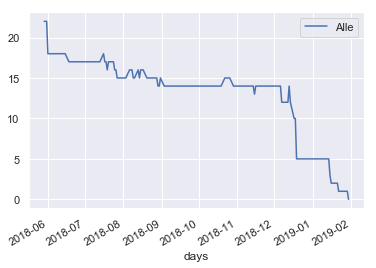

In [9]:

perc.plot(x='days')

In [11]:
perc.plot(x='days')
filename='out/'+ 'perc_over_time' +'.png'
plt.savefig(filename, dpi=300)
plt.close()